In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc,roc_curve
import os
from math import floor
import torch
# imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_path = "/content/drive/My Drive/AMMI_CV/project/train/train"
test_path = "/content/drive/My Drive/AMMI_CV/project/test/test/0"

In [0]:
os.listdir(train_path)

['healthy', 'cbsd', 'cmd', 'cgm', 'cbb']

In [0]:
# Delete extra images from the data
import glob
for folder in os.listdir(train_path): 
  for filename in glob.glob(os.path.join(train_path, folder) + "/extra*"):
    print (filename)
    break
    # os.remove(filename)


In [0]:
# # This function is used to calculate the meant and the std of our data set
# def image_mean_std(trainloader):
#     mean = 0.
#     std = 0.
#     for data,_ in trainloader:
#         batch_samples = data.size(0)
#         data = data.view(batch_samples, data.size(1), -1)
#         mean+= data.mean(2).mean(0)
#         std += data.std(2).mean(0)
        
#     mean /=len(trainloader)
#     std /= len(trainloader)
#     return mean, std
    

In [0]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler                                                          

# Data augmentation and normalization for training
# Just normalization for validation
transform =  transforms.Compose([
        transforms.RandomRotation(30),
        transforms.CenterCrop(500),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
       transforms.RandomAffine(50),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


full_dataset = datasets.ImageFolder(train_path, transform=transform)     

train_ind, val_ind = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42, shuffle=True, stratify= full_dataset.targets)

batch_size = 16 
class_sample_count = np.unique(full_dataset.targets, return_counts=True)[1]
# dataset has 10 class-1 samples, 1 class-2 samples, etc. 
weights = 1 / torch.Tensor(class_sample_count) 
weights = weights.double()
weights = weights[full_dataset.targets]
weights[val_ind] = 0
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(train_ind)) 

train_sampler = SubsetRandomSampler(train_ind)
valid_sampler = SubsetRandomSampler(val_ind)

class_names = full_dataset.classes
print(class_names)

trainloader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, sampler= train_sampler, num_workers=8)

testloader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=8)

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [0]:
# mean, std = image_mean_std(trainloader)

In [0]:
# mean, std = [0.4037, 0.4573, 0.2882],[0.2334, 0.2480, 0.1882]

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


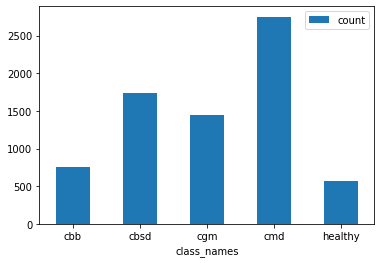

In [0]:
df = pd.DataFrame({'class_names':class_names, 'count':class_sample_count})
ax = df.plot.bar(x='class_names', y='count', rot=0)

In [0]:
model = models.resnext101_32x8d(pretrained=True) #SE-ResNeXt101_32x4d  #resnext50_32x4d
model

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [0]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.layer3[21:].parameters():
    param.requires_grad = True
for param in model.layer4[1:].parameters():
    param.requires_grad = True
  
model.fc = nn.Sequential(
      nn.Linear(2048, 5),
      #  nn.Linear(512, 5)
      )


In [0]:
print('Number of parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of parameters: 23,967,749


In [0]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [0]:
epochs = 35
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3, momentum=0.9, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.1,min_lr=1e-6, verbose=True)

train_size = len(trainloader)*batch_size
test_size = len(testloader)*batch_size
valid_loss_min = np.inf
top_1_train = []
top_1_test = []
model.to(device)
model.train()

# loop over the dataset multiple times
for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    losses_test = []
    losses_train = []
    # train for 1 epoch on the train set
    correct = 0

    for i, (batch, targets) in enumerate(trainloader):
        # batch and targets to cuda 
#        targets = one_hot_embedding(targets, 3)
        batch = batch.cuda()
        targets = targets.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        outputs = model(batch)
#        print(outputs)
        loss = criterion(outputs, targets)
        # backward
        loss.backward()
        
        # gradient step 
        optimizer.step()
#        scheduler.step()
        
        # compute accuracy 
#        pred = outputs # get the index of the max log-probability
        losses_train.append(loss.item())
        correct+= accuracy(outputs, targets)[0].item() * batch.size(0) / 100
        # if i %1==0:
        #   print('Epoch: {} batch number {}'.format(epoch,i))
#        losses+=loss.item()
    
    top_1 = correct / train_size * 100
    top_1_train.append(top_1)
    print('Train Acc: {:.2f}%'.format(top_1))
            
    # evaluate on the test set  
    model.eval()
    with torch.no_grad():
        correct = 0
        
        for i, (batch, targets) in enumerate(testloader):

            # batch and targets to cuda 
#            targets = one_hot_embedding(targets, 3)
            batch = batch.cuda()
            targets = targets.cuda()
            
            # forward 
            outputs = model(batch)
            loss = criterion(outputs, targets)
            
            # Store Losses
            losses_test.append(loss.item())
            
            # compute accuracy 
#            pred = outputs 
            correct += accuracy(outputs, targets)[0].item() * batch.size(0) / 100
            
    top_1 = correct / test_size * 100
    valid_loss = np.mean(losses_test)
#     scheduler.step(valid_loss)
    top_1_test.append(top_1)
    print('Test Acc: {:.2f}%'.format(top_1))
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/drive/My Drive/AMMI_CV/project/state_dict_model.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss

Epoch: 0
Train Acc: 89.32%
Test Acc: 90.93%
Validation loss decreased (inf --> 0.289029).  Saving model ...
Epoch: 1
Train Acc: 90.88%
Test Acc: 85.10%
Epoch: 2
Train Acc: 90.99%
Test Acc: 91.28%
Validation loss decreased (0.289029 --> 0.268282).  Saving model ...
Epoch: 3


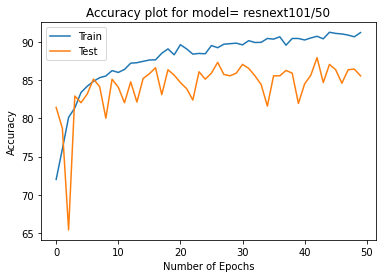

In [0]:
plt.plot(np.arange(epochs), top_1_train, label='Train')
plt.plot(np.arange(epochs), top_1_test, label='Test')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot for model= resnext101/50')
plt.legend()
plt.show()

In [0]:
submision_sample = pd.read_csv('/content/drive/My Drive/AMMI_CV/project/sample_submission_file.csv')
submision_sample.head()

,Category,Id
0,cbsd,test-img-0.jpg
1,cmd,test-img-1.jpg
2,cbb,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cbsd,test-img-4.jpg


In [0]:
test_path = "/content/drive/My Drive/AMMI_CV/project/test/test/0"
images = os.listdir(test_path)
images[:10]

['test-img-3543.jpg',
 'test-img-3535.jpg',
 'test-img-3473.jpg',
 'test-img-3480.jpg',
 'test-img-3570.jpg',
 'test-img-3569.jpg',
 'test-img-3576.jpg',
 'test-img-3577.jpg',
 'test-img-3544.jpg',
 'test-img-3469.jpg']

In [0]:
test_transform = transforms.Compose([
                # transforms.Resize((500,500)),
                transforms.CenterCrop(500),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

# test_dataset = datasets.ImageFolder(test_path, transform=transform) 
# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

In [0]:
import ttach as tta
from PIL import Image
model.load_state_dict(torch.load('/content/drive/My Drive/AMMI_CV/project/state_dict_model_101_final.pt'))
model.to(device)
model.eval()

# transforms = tta.Compose(
#     [   
#         tta.HorizontalFlip(),
#         tta.VerticalFlip(),
#         tta.Rotate90(angles=[180]),
#         tta.Scale(scales=[1, 2]),
#         tta.Multiply(factors=[0.9, 1]),        
#     ]
# )
# tta_model = tta.ClassificationTTAWrapper(model, transforms)

In [0]:
# submission_dict = {}
# submission_dict_101 = {}

# for i,image in enumerate(images):
    
#     image = Image.open(os.path.join(test_path,image))
#     image = test_transform(image).unsqueeze(0).to(device)
#     pred = model(image)
#     pred = [round(value, 2) for value in F.softmax(pred, dim=1).tolist()[0]]
#     if i%400==0:
#         print('image:', i, 'prediction: ', pred)
#     submission_dict[images[i]] = class_names[np.argmax(pred)]
#     submission_dict_101[images[i]] = pred


In [0]:
import json

with open('submission_dict_101_50.json', 'w') as fp:
    json.dump(submission_dict_101, fp)

In [0]:
# new_submission_dict = {k+'.jpg':v for k,v in submission_dict.items()}
submission = pd.DataFrame.from_dict(submission_dict, orient='index', columns=submision_sample.columns[1:])

submission.reset_index(inplace=True)

submission = submission.rename(columns={"Id": "Category", "index": "Id"})
submission = submission.reindex(columns=["Category","Id"])
submission.head()

,Category,Id
0,cmd,test-img-3543.jpg
1,cmd,test-img-3535.jpg
2,cmd,test-img-3473.jpg
3,cbb,test-img-3480.jpg
4,cbsd,test-img-3570.jpg


In [0]:
submission.to_csv('/content/drive/My Drive/AMMI_CV/project/submission_categories_7.csv', header=True, index=False)